In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

In [2]:
from mouse_record_dataloader import Mouse_records_dataset, Mouse_records_dataloader, Mouse_records_raw_dataloader, Mouse_records_raw_dataset

In [3]:
from torchvision import datasets
imagenet_root = "/mnt/lustre/datasets/ImageNet2012"
imagenet = datasets.ImageNet(imagenet_root, split='train')

In [4]:
dataset = Mouse_records_dataset(root='../train_xml')
dataset_raw = Mouse_records_raw_dataset(root='../train_xml')

In [167]:
REGULAR_TS = np.array([   
        0,  100,  200,  300,  400,  500,  600,  700,  800, 900, 
        1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,1800, 1900, 
        2000, 2100, 2200, 2300, 2400, 2500, 2600,2700, 2800, 2900, 
        # 3000., 3100., 3200., 3300., 3400., 3500.,3600., 3700., 3800., 3900.
        ])

DEFAULT_MOUSE_RECORD = np.array([np.ones_like(REGULAR_TS), np.ones_like(REGULAR_TS)], dtype=np.float32).T

In [69]:
_, _, mouse_record, _ = dataset[0]
selected_record, et, mouse_record_raw, _ = dataset_raw[0]
mouse_record[:, 0], mouse_record_raw[:, 1], mouse_record_raw[:, 0]-mouse_record_raw[0,0]

(array([0.895    , 0.7687119, 0.654521 , 0.6347161, 0.6383877, 0.6458547,
        0.1097697, 0.       , 0.       , 0.1634304, 0.65     , 0.65     ,
        0.65     , 0.65     , 0.65     , 0.65     , 0.65     , 0.65     ,
        0.65     , 0.65     , 0.65     , 0.65     , 0.65     , 0.65     ,
        0.65     , 0.65     , 0.65     , 0.65     , 0.65     , 0.65     ],
       dtype=float32),
 array([0.895, 0.865, 0.785, 0.705, 0.68 , 0.655, 0.64 , 0.635, 0.635,
        0.635, 0.635, 0.64 , 0.645, 0.65 ]),
 array([  0.,  54.,  93., 132., 159., 199., 250., 286., 315., 343., 378.,
        409., 468., 554.]))

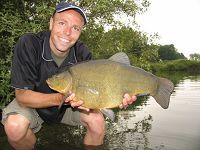

(None, (200, 150))

In [72]:
imagenet[1][0].show(), imagenet[1][0].size

In [73]:
def feature_to_pixels(x, y, width, height):
    return int(width * x), int(height * y)
def time_to_cmap(ts):
    return plt.cm.viridis((ts - ts.min()) / (ts.max() - ts.min()))

In [75]:
dataset_raw[0]

(array([[0.65      , 0.61333333]]),
 570.0,
 array([[0.00000000e+00, 8.95000000e-01, 4.93333333e-01],
        [5.40000000e+01, 8.65000000e-01, 7.13333333e-01],
        [9.30000000e+01, 7.85000000e-01, 8.53333333e-01],
        [1.32000000e+02, 7.05000000e-01, 9.80000000e-01],
        [1.59000000e+02, 6.80000000e-01, 1.00000000e+00],
        [1.99000000e+02, 6.55000000e-01, 9.80000000e-01],
        [2.50000000e+02, 6.40000000e-01, 8.60000000e-01],
        [2.86000000e+02, 6.35000000e-01, 6.73333333e-01],
        [3.15000000e+02, 6.35000000e-01, 6.66666667e-01],
        [3.43000000e+02, 6.35000000e-01, 6.46666667e-01],
        [3.78000000e+02, 6.35000000e-01, 6.40000000e-01],
        [4.09000000e+02, 6.40000000e-01, 6.26666667e-01],
        [4.68000000e+02, 6.45000000e-01, 6.13333333e-01],
        [5.54000000e+02, 6.50000000e-01, 6.13333333e-01]]),
 0)

In [181]:
def regularize_mouse_record(mouse_record, estimate_time, point_fg, k=3):
        default_mouse_record = DEFAULT_MOUSE_RECORD.copy()
        try:
            t0 = mouse_record[0,0]
            mouse_record[:,0] = mouse_record[:,0] - t0
            tf = min(mouse_record[-1,0], estimate_time)
            idxf = min(int(tf//100) + 1, len(REGULAR_TS)-1)
            if (mouse_record[:,0]<estimate_time).sum() < k+1:
                idxf = "Throw an error"

            bspl = make_interp_spline(mouse_record[:,0], mouse_record[:, 1:].T, k=k,axis=1)
            default_mouse_record[:idxf] = bspl(REGULAR_TS[:idxf].copy()).T
            mask_away = np.logical_not(np.any(default_mouse_record > 1, axis=1)|np.any(default_mouse_record < 0, axis=1))[:, None]
            default_mouse_record = mask_away * default_mouse_record
            default_mouse_record[idxf:] *= point_fg
            return default_mouse_record
            # return default_mouse_record

        except Exception as e: 
            # print(f"Error: {e}")#, mouse_record: ts : {mouse_record[:,0]-t0}, x-y: {mouse_record[:,1:]}")
            # continue
            return DEFAULT_MOUSE_RECORD*0.

def plot_og_vs_interp_dev(imagenet_idx, ab_idx, lim = True, k=3):
    im, lb = imagenet[imagenet_idx]
    plt.imshow(im)

    fg, et, mouse_record,_ = dataset_raw[ab_idx]
    # _, _, mouse_record_inter,_ = dataset[ab_idx]
    mouse_record_inter = regularize_mouse_record(mouse_record, et, point_fg=fg, k=k)

    mouse_record_pixels = [feature_to_pixels(x,y, im.width, im.height) for _,x, y in mouse_record]
    cmap = time_to_cmap(np.asarray([ t-mouse_record[0,0] for t, _, _ in mouse_record]))

    x,y = zip(*mouse_record_pixels)
    plt.scatter(x, y, color = cmap, label="Recorded time series", s=200, edgecolors='black')
    plt.colorbar()
    mouse_record_pixels_interp = [feature_to_pixels(x,y, im.width, im.height) for x, y in mouse_record_inter]
    cmap = time_to_cmap(np.asarray([100*i/3900 for i, _ in enumerate(mouse_record_inter)]))
    plt.scatter(*zip(*mouse_record_pixels_interp), color=cmap, label="Interpolated time series", marker='*', s=200, edgecolors='black')

    if lim:
        plt.xlim(0, im.width)
        plt.ylim(im.height, 0)
    plt.legend()
    plt.show()

In [77]:
mouse_record = np.load('data/mouse_record_interpolated.npy')

In [78]:
# Clean data aka reasonable estimated time
subset = np.logical_not(np.load("data/missing_file_names_mask.npy")) # Makes losses adapt to the selected mouse_records
losses = np.load("data/resnet50_losses_final_weights.npy")[subset]
mouse_records = np.load("data/mouse_record_interpolated.npy")
estimate_times=np.load('data/sample_estimate_times.npy')
clean_subset = estimate_times[subset] < 3000
clean_subset = np.logical_and(clean_subset, estimate_times[subset] > 0)
clean_id_to_dataset_id = np.arange(len(dataset))[clean_subset]
assert np.allclose(mouse_records[clean_subset][8900], mouse_records[clean_id_to_dataset_id[8900]])

In [80]:
def find_imagenet_idx(clean_id):
    dataset_id = clean_id_to_dataset_id[clean_id]
    target_path = dataset.samples[dataset_id][0].split('/')[-1].split('.')[0]
    for i in range(len(imagenet.samples)-dataset_id):
        if target_path in imagenet.samples[i][0]:
            return i

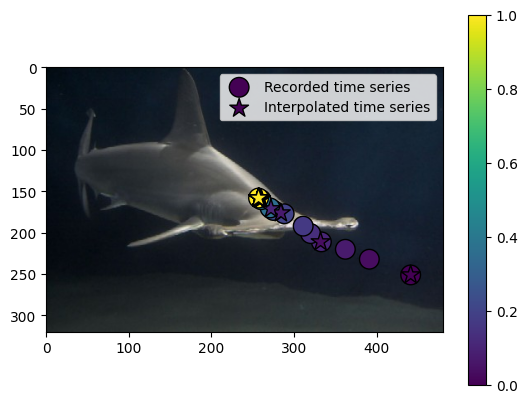

In [182]:
i = 4906
imagenet_id = find_imagenet_idx(i)
dataset_id = clean_id_to_dataset_id[i]
plot_og_vs_interp_dev(imagenet_id, dataset_id, lim=True, k=1)

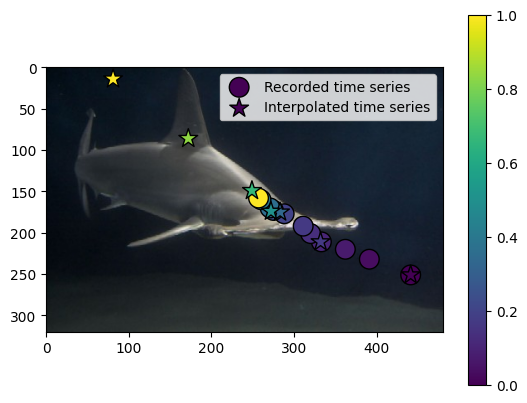

In [21]:
i = 4906
imagenet_id = find_imagenet_idx(i)
dataset_id = clean_id_to_dataset_id[i]
plot_og_vs_interp(imagenet_id, dataset_id, lim=True)

xml_file: ../train_xml/n01494475/n01494475_169.xml


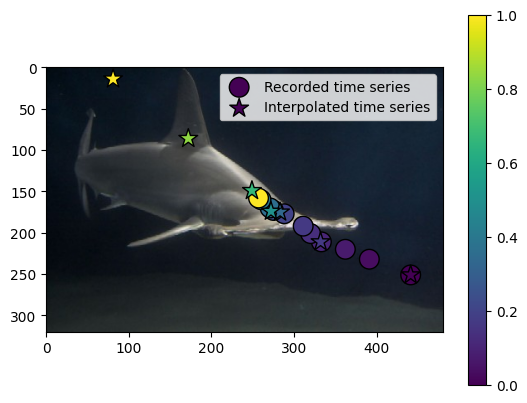

In [25]:
i = 4906
imagenet_id = find_imagenet_idx(i)
dataset_id = clean_id_to_dataset_id[i]
plot_og_vs_interp(imagenet_id, dataset_id, lim=True)

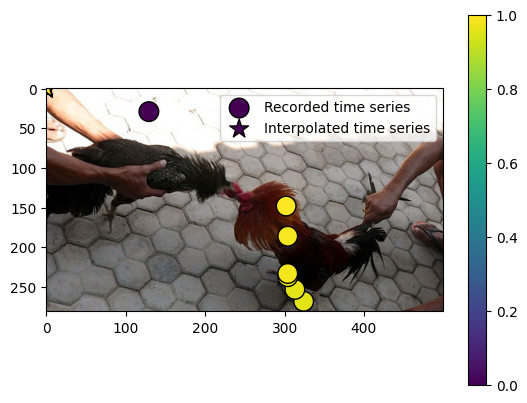

In [183]:
imagenet_id = find_imagenet_idx(8900)
dataset_id = clean_id_to_dataset_id[8900]
plot_og_vs_interp_dev(imagenet_id, dataset_id, lim=False, k=1)

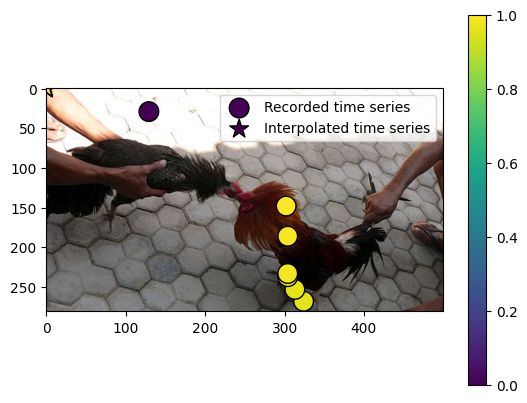

In [22]:
plot_og_vs_interp(imagenet_id, dataset_id, lim=False)

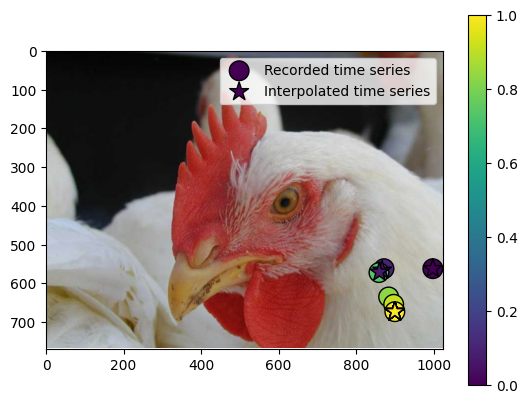

In [184]:
imagenet_id = find_imagenet_idx(9746)
dataset_id = clean_id_to_dataset_id[9746]
plot_og_vs_interp_dev(imagenet_id, dataset_id, lim=True, k=1)

/tmp/ipykernel_1284260/2843064980.py:4: RuntimeWarning: invalid value encountered in divide
  return plt.cm.viridis((ts - ts.min()) / (ts.max() - ts.min()))


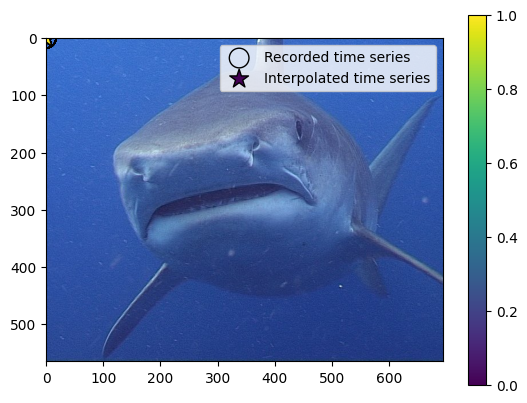

In [185]:
imagenet_id = find_imagenet_idx(4345)
dataset_id = clean_id_to_dataset_id[4345]
plot_og_vs_interp_dev(imagenet_id,dataset_id, k=1)

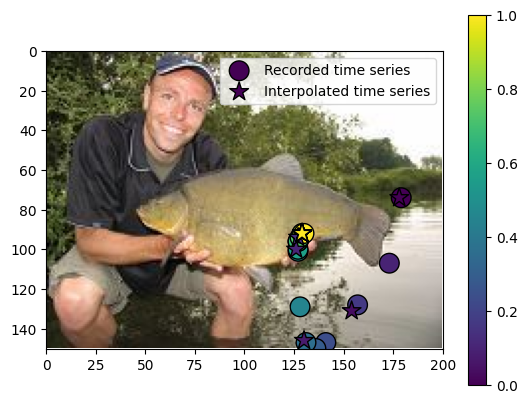

In [186]:
imagenet_id = find_imagenet_idx(0)
dataset_id = clean_id_to_dataset_id[0]
plot_og_vs_interp_dev(imagenet_id,dataset_id, k=1)

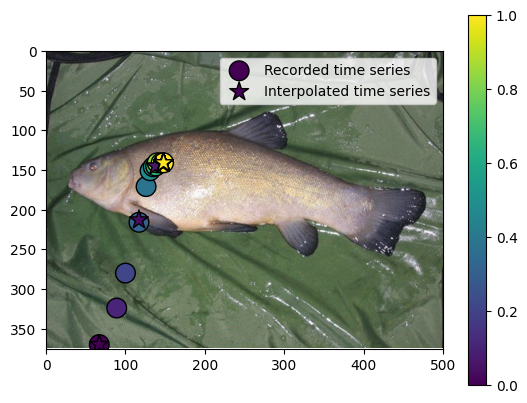

In [187]:
plot_og_vs_interp(2,1)

/tmp/ipykernel_1284260/2843064980.py:4: RuntimeWarning: invalid value encountered in divide
  return plt.cm.viridis((ts - ts.min()) / (ts.max() - ts.min()))


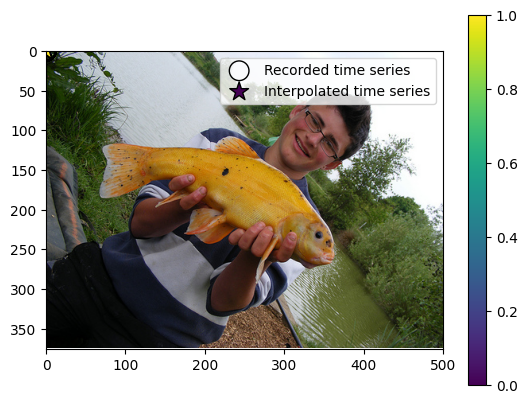

In [188]:
plot_og_vs_interp(3,2)

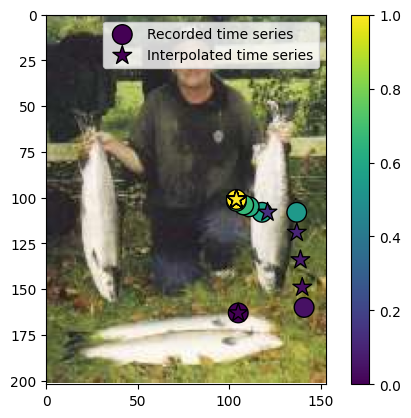

In [192]:
plot_og_vs_interp_dev(4,3, k=1)